In [ ]:
!nvidia-smi

Mon Feb  8 21:27:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# EYE GAZE SHARED TASK

In [1]:
import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.metrics import r2_score

In [2]:
!pip install transformers

     |████████████████████████████████| 1.8MB 4.2MB/s 
     |████████████████████████████████| 3.2MB 17.5MB/s 
     |████████████████████████████████| 890kB 38.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=1b77ff056552d6c1068890ef2f07b25a591617fe1f9ed1611d3d9633fd629ef3
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


### IMPORT TRANSFORMERS

In [4]:
from transformers import BertTokenizer, BertForTokenClassification, BertModel
#from transformers import AlbertTokenizer, AlbertModel
#from transformers import ElectraForTokenClassification, ElectraTokenizer
#from transformers import RobertaForTokenClassification, RobertaTokenizer

#tokenizer = RobertaTokenizer.from_pretrained("roberta-base", add_prefix_space = True)
#base_model = RobertaForTokenClassification.from_pretrained("roberta-base")

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
#base_model = BertForTokenClassification.from_pretrained("bert-base-uncased")
base_model = BertModel.from_pretrained("bert-base-uncased")

#tokenizer = ElectraTokenizer.from_pretrained("google/electra-small-discriminator")
#base_model = ElectraForTokenClassification.from_pretrained("google/electra-small-discriminator")

### DOWNLOAD DATA

In [8]:
train_data_file_path = "/content/drive/My Drive/CMCL Shared Task/preprocessed_dataset.csv"
#file_path = "/content/drive/MyDrive/datasets/EyeGazeSharedTask/trial_data.csv"

train_data = pd.read_csv(train_data_file_path)
temp_df = pd.read_csv("/content/drive/My Drive/CMCL Shared Task/Sentences_maxlen.csv")
sentences = list(temp_df["sentences"])
MAX_LEN = temp_df["max_len"]

In [9]:
print("Train Data Shape = ", train_data.shape)
train_data

Train Data Shape =  (15736, 37)


,sentence_id,word_id,word,nFix,FFD,GPT,TRT,fixProp,endword,n_tokens,cf_n_tokens,n_chars,n_char_lemmatized,stopword,number,tags,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,tf_idf
0,0,0,Carlucci,1.410757,1.020764,1.093189,1.382395,1.038428,-1,2,2,8,0,-1,-1,VB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.178778
1,0,1,was,-0.224947,0.241393,0.071056,-0.204384,0.361232,-1,1,3,3,1,1,-1,VB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.060409
2,0,2,deputy,1.066398,1.841063,0.053680,1.053315,1.264160,-1,1,4,6,0,-1,-1,NN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.178778
3,0,3,defense,0.549860,1.455642,0.274461,0.837481,0.812696,-1,1,5,7,0,-1,-1,NN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.310704
4,0,4,secretary,0.291591,0.664334,0.466622,0.103379,0.812696,-1,1,6,9,0,-1,-1,NN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.275261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15731,799,4,and,-0.382778,0.095297,-0.282289,-0.412446,0.198203,-1,1,7,3,0,1,-1,DT,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.118080
15732,799,5,patient,0.918133,1.433756,0.341808,0.852136,1.264160,-1,1,8,7,0,-1,-1,VB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.454322
15733,799,6,wife,0.348984,0.340117,-0.191064,0.373357,0.411395,-1,1,9,4,0,-1,-1,NN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.343320
15734,799,7,of,-0.057551,0.836201,-0.998577,0.221104,0.411395,-1,1,10,2,0,1,-1,NN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.123557


### BASIC MODEL PLAN

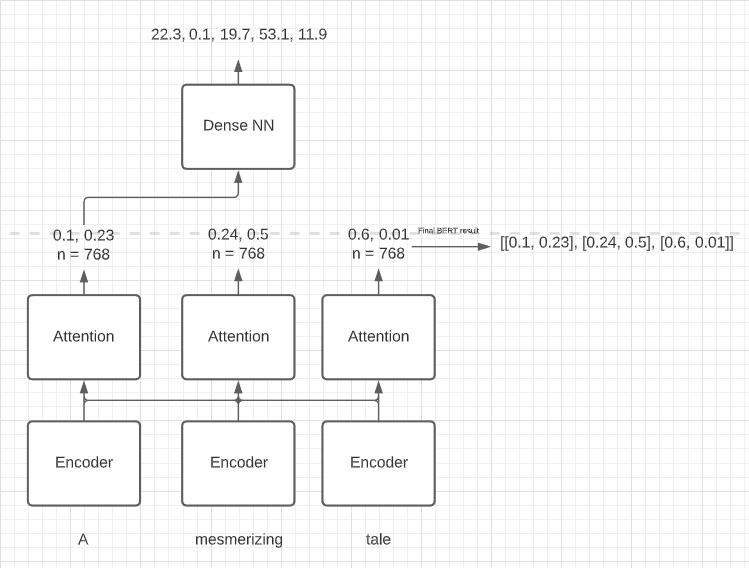

Steps:-

1. Form Sentences using (Sentence_id, Word_id). This creates 100 sentences of varying lengths.
2. Pad the sentences to the maximum sentence length.
3. Pass the sentence to a BERT model without the final Bert Pooler Layer. This creates a tensor of _(Batch_size, seq_length, hidden_size)_
4. Pass the final tensor to a Dense Neural Network where the final output should be _(Batch_size, Seq_length, 5)_.
5. Compare the output to the 5 target variables for each word and calculate loss.
6. Use backprop for gradient descent.

### IMPORT TOKENIZERS


























































### PREPROCESS DATA

#### REMOVE EOS TOKEN

In [ ]:
def remove_eos(df):
  cnt = 1
  for i in range(df.shape[0]-1):
    if (df.loc[i+1, "sentence_id"] == cnt):
      df.loc[i, "word"] = df.loc[i, "word"][:-5]   # Remove <EOS> for the last word of each sentence.
      cnt += 1 
  s = df.loc[df.shape[0] - 1, "word"]              # Remove <EOS> for last element separately
  df.loc[df.shape[0] - 1, "word"] = s[:-6] 
  return df

### COUNT NO OF TOKENS FOR EACH WORD

In [ ]:
# Adding a column for no of tokens for each word
def add_token_per_words(df):
  n_tokens_per_word = []
  cdf = 0
  cf_n_token_per_word = []
  for i, word in enumerate(df.word):
    n_tokens_per_word.append(len(tokenizer.encode(word)) - 2)
    if (i > 0) and (df.loc[i-1, "sentence_id"] != df.loc[i, "sentence_id"]):
      cdf = 0
    cdf += len(tokenizer.encode(word)) - 2
    cf_n_token_per_word.append(cdf)
  df["n_tokens"] = n_tokens_per_word
  df["cf_n_tokens"] = cf_n_token_per_word
  return df

### NO OF CHARS FOR EACH WORD

In [ ]:
def char_per_word(df):
  n_chars = []
  for word in df.word:
    n_chars.append(len(str(word)))
  df["n_chars"] = n_chars
  return df

### NO OF CHARS OF WORD - LEMMATIZED WORD

In [ ]:
from nltk import WordNetLemmatizer

Lemmatizer = WordNetLemmatizer()

def char_per_lemmatized_word(df):
  n_chars = []
  for word in df.word:
    n_chars.append(len(str(word)) - len(Lemmatizer.lemmatize(word)))
  df["n_char_lemmatized"] = n_chars
  return df

### STOP WORD OR NOT

In [ ]:
import nltk
nltk.download("stopwords")
nltk.download("wordnet")

stopwords = nltk.corpus.stopwords
stop_words = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
def add_stopword_check(df):
  if_stopword = []
  for word in df.word:
    if_stopword.append(int(word in stop_words))

  df["stopword"] = if_stopword
  return df

### NUMBER OR NOT

In [ ]:
def add_number_check(df):
  if_number = []
  for word in df.word:
    if_number.append(int(word.isdigit()))

  df["number"] = if_number
  return df

### TF IDF CALCULATION

In [ ]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words=None)
bad_words = []
punc = string.punctuation

def remove_punc(word):
  table = str.maketrans('', '', punc)
  return word.translate(table)

def calc_tfidf(df):
  n = np.array(df["sentence_id"])[-1]
  sentences = []
  tf_idfs = []
  for i in range(n+1):   
    temp_df = df[df.sentence_id == i]
    sentence = (' ').join(np.array(temp_df.word))
    sentences.append(sentence)
  tf_idf = vectorizer.fit_transform(sentences)
  for i, word in enumerate(df.word):
    try:
      tf_idfs.append(tf_idf.toarray()[df["sentence_id"][i]][vectorizer.get_feature_names().index(remove_punc(word.lower()))])
    except:
      bad_words.append(word)
      if word in ["a", "A"]:
        tf_idfs.append(0.8)
      else:
        tf_idfs.append(0.01)
  df["tf_idf"] = tf_idfs

  return sentences, df, bad_words

In [ ]:
def preprocess(df):
  return add_number_check(add_stopword_check(char_per_lemmatized_word(char_per_word(add_token_per_words(remove_eos(df))))))
df_temp = preprocess(train_data)
df1 = df_temp.copy()
df1

,sentence_id,word_id,word,nFix,FFD,GPT,TRT,fixProp,n_tokens,cf_n_tokens,n_chars,n_char_lemmatized,stopword,number
0,0,0,Carlucci,28.397566,4.642973,6.190631,10.343594,94.117647,2,2,8,0,0,0
1,0,1,was,12.981744,3.534385,5.263977,4.565348,76.470588,1,3,3,1,1,0
2,0,2,deputy,25.152130,5.809781,9.926357,9.145251,100.000000,1,4,6,0,0,0
3,0,3,defense,20.283976,5.261551,8.092455,8.359293,88.235294,1,5,7,0,0,0
4,0,4,secretary,17.849899,4.135982,4.507129,5.686066,88.235294,1,6,9,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15731,799,4,and,11.494253,3.326575,6.183489,3.807691,72.222222,1,7,3,0,1,0
15732,799,5,patient,23.754789,5.230420,7.826157,8.412660,100.000000,1,8,7,0,0,0
15733,799,6,wife,18.390805,3.674811,8.611980,6.669187,77.777778,1,9,4,0,0,0
15734,799,7,of,14.559387,4.380448,11.890443,6.114758,77.777778,1,10,2,0,1,0


### FORM SENTENCES

In [ ]:
sentences, df, bad_words = calc_tfidf(df_temp)
df

,sentence_id,word_id,word,nFix,FFD,GPT,TRT,fixProp,n_tokens,cf_n_tokens,n_chars,n_char_lemmatized,stopword,number,tf_idf
0,0,0,Carlucci,28.397566,4.642973,6.190631,10.343594,94.117647,2,2,8,0,0,0,0.178778
1,0,1,was,12.981744,3.534385,5.263977,4.565348,76.470588,1,3,3,1,1,0,0.060409
2,0,2,deputy,25.152130,5.809781,9.926357,9.145251,100.000000,1,4,6,0,0,0,0.178778
3,0,3,defense,20.283976,5.261551,8.092455,8.359293,88.235294,1,5,7,0,0,0,0.310704
4,0,4,secretary,17.849899,4.135982,4.507129,5.686066,88.235294,1,6,9,0,0,0,0.275261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15731,799,4,and,11.494253,3.326575,6.183489,3.807691,72.222222,1,7,3,0,1,0,0.118080
15732,799,5,patient,23.754789,5.230420,7.826157,8.412660,100.000000,1,8,7,0,0,0,0.454322
15733,799,6,wife,18.390805,3.674811,8.611980,6.669187,77.777778,1,9,4,0,0,0,0.343320
15734,799,7,of,14.559387,4.380448,11.890443,6.114758,77.777778,1,10,2,0,1,0,0.123557


In [ ]:
print("No of words unaccounted for = ", len(bad_words))

No of words unaccounted for =  974


In [ ]:
from sklearn.preprocessing import normalize

def normalize_target(df):
  keys = df.keys()[3:8]
  new_df = pd.DataFrame(normalize(df.iloc[:,3:8], axis = 0, copy = True), columns = keys)
  df.update(new_df)
  return 
#normalize_target(df)
df

,sentence_id,word_id,word,nFix,FFD,GPT,TRT,fixProp,n_tokens,cf_n_tokens,n_chars,n_char_lemmatized,stopword,number,tf_idf
0,0,0,Carlucci,28.397566,4.642973,6.190631,10.343594,94.117647,2,2,8,0,0,0,0.178778
1,0,1,was,12.981744,3.534385,5.263977,4.565348,76.470588,1,3,3,1,1,0,0.060409
2,0,2,deputy,25.152130,5.809781,9.926357,9.145251,100.000000,1,4,6,0,0,0,0.178778
3,0,3,defense,20.283976,5.261551,8.092455,8.359293,88.235294,1,5,7,0,0,0,0.310704
4,0,4,secretary,17.849899,4.135982,4.507129,5.686066,88.235294,1,6,9,0,0,0,0.275261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15731,799,4,and,11.494253,3.326575,6.183489,3.807691,72.222222,1,7,3,0,1,0,0.118080
15732,799,5,patient,23.754789,5.230420,7.826157,8.412660,100.000000,1,8,7,0,0,0,0.454322
15733,799,6,wife,18.390805,3.674811,8.611980,6.669187,77.777778,1,9,4,0,0,0,0.343320
15734,799,7,of,14.559387,4.380448,11.890443,6.114758,77.777778,1,10,2,0,1,0,0.123557


In [ ]:
'''
def form_sentences(df):
  n = np.array(df["sentence_id"])[-1]
  sentences = []
  max_len = 0
  for i in range(n+1):   
    temp_df = df[df.sentence_id == i]
    sentence = (' ').join(np.array(temp_df.word))
    sentences.append([sentence])
    max_len = max(max_len, len(sentence))

  return sentences, max_len

sentences, max_len = form_sentences(df_temp)
print(f"No of Sentences {len(sentences)} and Max Sentence Length = {max_len} ")
sentences[4]
'''

'\ndef form_sentences(df):\n  n = np.array(df["sentence_id"])[-1]\n  sentences = []\n  max_len = 0\n  for i in range(n+1):   \n    temp_df = df[df.sentence_id == i]\n    sentence = (\' \').join(np.array(temp_df.word))\n    sentences.append([sentence])\n    max_len = max(max_len, len(sentence))\n\n  return sentences, max_len\n\nsentences, max_len = form_sentences(df_temp)\nprint(f"No of Sentences {len(sentences)} and Max Sentence Length = {max_len} ")\nsentences[4]\n'

### FORM TARGETS

In [11]:
from sklearn.preprocessing import normalize

def form_targets(df):
  n = np.array(df["sentence_id"])[-1]
  targets = []
  cdfs = []
  char_lens = []
  if_stopwords = []
  if_nums = []
  char_lens_lemmatized = []
  tfidfs = []
  for i in range(n+1):
    temp_df = df[df.sentence_id == i]
    target = np.array(temp_df.iloc[:, 3:8])
    cdf = temp_df.loc[:,"cf_n_tokens"]
    char_len = temp_df.loc[:, "n_chars"]
    if_stopword = temp_df.loc[:, "stopword"]
    if_num = temp_df.loc[:, "number"]
    char_len_lemmatized = temp_df.loc[:, "n_char_lemmatized"]
    tfidf = temp_df.loc[:, "tf_idf"]
    
    targets.append(target)
    cdfs.append(np.array(cdf))
    char_lens.append(np.array(char_len))
    char_lens_lemmatized.append(np.array(char_len_lemmatized))
    if_stopwords.append(np.array(if_stopword))
    if_nums.append(np.array(if_num))
    tfidfs.append(np.array(tfidf))
 
  return targets, cdfs, char_lens, char_lens_lemmatized, if_stopwords, if_nums, tfidfs

df_temp = train_data.copy()
targets, cdfs, char_lens, char_lens_lemmatized, if_stopwords, if_nums, tfidfs = form_targets(df_temp)
print("Target Shape = ", np.array(targets, dtype = "object").shape)
print("Cumulative Freq Label shape = ",np.array(cdfs, dtype = "object").shape)

Target Shape =  (800,)
Cumulative Freq Label shape =  (800,)


### IMPORT TOKENIZERS AND MODELS

In [12]:
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### FORMING CLASS OF DATA

In [14]:
# Class for the data
# Contains 4 keys -> Sentences, targets, input_ids(for BERT), attention_mask(for BERT) 

class EyeGaze_dataset(Dataset):
  def __init__(self, sentencess, targets, cdfs, char_lens, char_lens_lemmatized, if_stopwords, if_nums, tfidfs, tokenizer):
    self.sentences = sentences               # List of Sentences
    self.targets = targets                   # List of Padded Targets
    self.tokenizer = tokenizer               # Tokenizer to be used (BERT)
    self.cdfs = cdfs                         # Cumulative Frequency Function
    self.char_lens = char_lens               # Cumulative Frequency Function
    self.if_stopwords = if_stopwords         # Cumulative Frequency Function
    self.if_nums = if_nums                   # Cumulative Frequency Function
    self.tfidfs = tfidfs
    self.char_lens_lemmatized = char_lens_lemmatized
  
  def __len__(self):
    return len(self.sentences)               # No of Examples = 100

  def __getitem__(self, index):
    sentence = str(self.sentences[index])        # Get the review at the particular index
    target = self.targets[index]                    # Get the target label at the particular index
    cdf = self.cdfs[index]
    char_len = self.char_lens[index]
    char_len_lemmatized = self.char_lens_lemmatized[index]
    if_stopword = self.if_stopwords[index]
    if_num = self.if_nums[index]
    tfidf = self.tfidfs[index]

    encoding = self.tokenizer.encode_plus(   # Encoder encoding the particular review
        sentence,
        return_attention_mask = True,
        return_tensors = "pt"
    )
    # The class simply returns a dictionary of the following
    return {"sentences": sentence,
            "targets":torch.tensor(target, dtype = torch.float32),
            "input_ids":encoding["input_ids"].flatten(),
            "attention_masks":encoding["attention_mask"].flatten(),
            "cdfs" : cdf,
            "char_len":torch.tensor(char_len, dtype = torch.float32) ,
            "char_len_lemmatized" : torch.tensor(char_len_lemmatized, dtype = torch.float32),
            "if_stopword" : torch.tensor(if_stopword, dtype = torch.float32),
            "if_num": torch.tensor(if_num, dtype = torch.float32),
            "tfidf": torch.tensor(tfidf, dtype = torch.float32) 
            }


In [15]:
# Forms the DataLoaders with test_size = 0.2
# Each DataLoader has the Class dataset as their elements
def create_data_loader(sentences, targets, cdfs, char_lens, char_lens_lemmatized, if_stopwords, if_nums, tfidfs, tokenizer, batch_size):
  data = EyeGaze_dataset(sentences, targets, cdfs, char_lens, char_lens_lemmatized, if_stopwords, if_nums, tfidfs, tokenizer)
  train, val = train_test_split(data, test_size = 0.3, shuffle = False)
  train_data_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
  val_data_loader = DataLoader(val, batch_size = batch_size, shuffle = False)
  
  return train_data_loader, val_data_loader

BATCH_SIZE = 1
train_data_loader, val_data_loader = create_data_loader(sentences, targets, cdfs, char_lens, char_lens_lemmatized, if_stopwords, if_nums, tfidfs, tokenizer, BATCH_SIZE)

In [16]:
temp = next(iter(train_data_loader))
print(temp.keys())
keys = ['targets', 'input_ids', 'attention_masks', 'cdfs', 'char_len', 'char_len_lemmatized', 'if_stopword', 'if_num', 'tfidf']
for key in keys:
  print(temp[key].size())

dict_keys(['sentences', 'targets', 'input_ids', 'attention_masks', 'cdfs', 'char_len', 'char_len_lemmatized', 'if_stopword', 'if_num', 'tfidf'])
torch.Size([1, 45, 5])
torch.Size([1, 54])
torch.Size([1, 54])
torch.Size([1, 45])
torch.Size([1, 45])
torch.Size([1, 45])
torch.Size([1, 45])
torch.Size([1, 45])
torch.Size([1, 45])


Sentences Shape = _(100, variable)_

Tokens Shape = _(100, 320)_

Hidden Shape = _(100, 320, 768)_

Final Output Shape = _(100, 320, 5)_

Target Shape = _(100, 320, 5)_

In [17]:
#base_model.config.output_hidden_states = True
base_model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.3.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [18]:
class LanguageHeadLayer(torch.nn.Module):
  def __init__(self):
    super(LanguageHeadLayer, self).__init__()
    self.mid = torch.nn.Linear(in_features = base_model.config.hidden_size, out_features = 1024)
    self.dense = torch.nn.Linear(in_features = 1024, out_features = 1024)
    self.out = torch.nn.Linear(in_features = 1024, out_features = 256)
    self.act1 = torch.nn.ReLU()
    self.act2 = torch.nn.GELU()
    self.drop = torch.nn.Dropout(p = 0.5)

  def forward(self, output):
    output = self.mid(output)
    output = self.act2(output)
    output = self.drop(output)
    output = self.dense(output)
    output = self.act2(output)
    output = self.drop(output)
    #output = self.out(output)

    return output
    
class ExtraFeatureModel(torch.nn.Module):
  def __init__(self):
    super(ExtraFeatureModel, self).__init__()
    self.inp = torch.nn.Linear(in_features = 5, out_features = 64)
    self.out = torch.nn.Linear(in_features = 64, out_features = 256)
    self.act = torch.nn.ReLU()
    self.drop = torch.nn.Dropout(p = 0.3)

  def forward(self, features):
    output = self.inp(features)
    output = self.act(output)
    output = self.drop(output)
    output = self.out(output)
    return output

In [30]:
class EyeGazeClassifier(torch.nn.Module):
  def __init__(self):
    super(EyeGazeClassifier, self).__init__()
    self.base_model = base_model
    self.languageheadlayer = LanguageHeadLayer()
    self.feature_model = ExtraFeatureModel()
    self.out = torch.nn.Linear(in_features = 1024, out_features = 5)
    self.dense1 = torch.nn.Linear(768, 1024)
    self.act = torch.nn.ReLU()
    self.drop = torch.nn.Dropout(p = 0.5)
    self.dense2 = torch.nn.Linear(1024, 1024)
    #self.conv = torch.nn.Conv2d(in_channels = 2, out_channels = 4, kernel_size = [2, 3], stride = 1, padding = )

  def map_predictions(self, output, attention_mask, cdf):
    attention_mask[0][0] = 0
    attention_mask[0][-1] = 0
    attention_mask = torch.unsqueeze(attention_mask, dim = 2)
    output = torch.mul(output, attention_mask)[0]
    pred_tensor = torch.unsqueeze(torch.mean(output[1:cdf[0]+1], dim = 0), dim = 0)
    for i in range(0, len(cdf)-1):
      y = torch.unsqueeze(torch.mean(output[cdf[i]+1:cdf[i+1]+1], dim = 0), dim = 0)
      pred_tensor = torch.cat((pred_tensor, y), dim = 0)
    return pred_tensor

  def forward(self, input_ids, attention_mask, cdf, extra_features):
    lang_output = self.base_model(input_ids = input_ids, attention_mask = attention_mask)
    lang_output = self.map_predictions(lang_output["last_hidden_state"], attention_mask, cdf)    # For Token Classification Models
    output = self.dense1(lang_output)
    output = self.act(output)
    output = self.drop(output)
    output = self.dense2(output)
    output = self.act(output)
    output = self.drop(output)
    #lang_output = self.languageheadlayer(lang_output)
    #feature_output = self.feature_model(extra_features)
    #output = torch.cat((torch.unsqueeze(lang_output, dim = 2), torch.unsqueeze(feature_output), dim = 2), dim = 2)
    #output = 
    #output = (output+feature_output)/2
    output = self.out(output)
    
    return output


In [31]:
del model

In [32]:
model = EyeGazeClassifier()
model = model.to(device)

### TRAINING

In [23]:
EPOCHS = 150
from transformers import AdamW, get_linear_schedule_with_warmup
optimizer = AdamW(model.parameters(), lr=2e-5, betas = (0.9, 0.999), correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=10,
  num_training_steps=total_steps
)

loss_fn = nn.L1Loss(reduction = 'sum').to(device)

In [24]:
def target_initialise():
  targets = {}
  outputs = {}

  targets["r20"] = torch.tensor([], dtype = torch.float32)
  targets["r21"] = torch.tensor([], dtype = torch.float32)
  targets["r22"] = torch.tensor([], dtype = torch.float32)
  targets["r23"] = torch.tensor([], dtype = torch.float32)
  targets["r24"] = torch.tensor([], dtype = torch.float32)

  outputs["pred_r20"] = torch.tensor([], dtype = torch.float32)
  outputs["pred_r21"] = torch.tensor([], dtype = torch.float32)
  outputs["pred_r22"] = torch.tensor([], dtype = torch.float32)
  outputs["pred_r23"] = torch.tensor([], dtype = torch.float32)
  outputs["pred_r24"] = torch.tensor([], dtype = torch.float32)
  
  return targets, outputs

In [25]:
def store_targets(targets, target):
  targets["r20"] = torch.cat([targets["r20"], target[0,:,0].detach().cpu()], dim = 0)
  targets["r21"] = torch.cat([targets["r21"], target[0,:,1].detach().cpu()], dim = 0)
  targets["r22"] = torch.cat([targets["r22"], target[0,:,2].detach().cpu()], dim = 0)
  targets["r23"] = torch.cat([targets["r23"], target[0,:,3].detach().cpu()], dim = 0)
  targets["r24"] = torch.cat([targets["r24"], target[0,:,4].detach().cpu()], dim = 0)

  return targets  

def store_outputs(outputs, output):
  outputs["pred_r20"] = torch.cat([outputs["pred_r20"], output[0,:,0].detach().cpu()], dim = 0)
  outputs["pred_r21"] = torch.cat([outputs["pred_r21"], output[0,:,1].detach().cpu()], dim = 0)
  outputs["pred_r22"] = torch.cat([outputs["pred_r22"], output[0,:,2].detach().cpu()], dim = 0)
  outputs["pred_r23"] = torch.cat([outputs["pred_r23"], output[0,:,3].detach().cpu()], dim = 0)
  outputs["pred_r24"] = torch.cat([outputs["pred_r24"], output[0,:,4].detach().cpu()], dim = 0)
  
  return outputs

In [26]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
  model = model.train()

  losses = []
  targets, outputs = target_initialise()  
  
  r2 = {}
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_masks"].to(device)
    target = d["targets"].to(device)
    cdf = d["cdfs"].to(device)
    char_len = torch.unsqueeze(d["char_len"], dim = 2)
    char_len_lemmatized = torch.unsqueeze(d["char_len_lemmatized"], dim = 2)
    if_stopword = torch.unsqueeze(d["if_stopword"], dim = 2)
    if_num = torch.unsqueeze(d['if_num'], dim = 2)
    tfidf = torch.unsqueeze(d["tfidf"], dim = 2)


    targets = store_targets(targets, target)
    extra_feature = torch.cat((char_len, char_len_lemmatized, if_stopword, if_num, tfidf), dim = 2).to(device)

    output = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      cdf = cdf[0],
      extra_features = extra_feature[0]
      )

    output = torch.unsqueeze(output, dim = 0)
    outputs = store_outputs(outputs, output)
    
    loss = loss_fn(output, target)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  
  r2["nFix"] = r2_score(targets["r20"].numpy(), outputs["pred_r20"].numpy())
  r2["FFD"] = r2_score(targets["r21"].numpy(), outputs["pred_r21"].numpy())
  r2["GPT"] = r2_score(targets["r22"].numpy(), outputs["pred_r22"].numpy())
  r2["TRT"] = r2_score(targets["r23"].numpy(), outputs["pred_r23"].numpy())
  r2["fixProp"] = r2_score(targets["r24"].numpy(), outputs["pred_r24"].numpy())
  
  return np.mean(losses), r2    # correct_predictions.double() / n_examples,

In [27]:
def eval_model(model, data_loader, loss_fn, device):
  model = model.eval()

  losses = []
  outputs = []
  r2 = {}
  targets, outputs = target_initialise()  
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_masks"].to(device)
      target = d["targets"].to(device)
      cdf = d["cdfs"].to(device)
      char_len = torch.unsqueeze(d["char_len"], dim = 2)
      char_len_lemmatized = torch.unsqueeze(d["char_len_lemmatized"], dim = 2)
      if_stopword = torch.unsqueeze(d["if_stopword"], dim = 2)
      if_num = torch.unsqueeze(d['if_num'], dim = 2)
      tfidf = torch.unsqueeze(d["tfidf"], dim = 2)   
    
      targets = store_targets(targets, target)
      extra_feature = torch.cat((char_len, char_len_lemmatized, if_stopword, if_num, tfidf), dim = 2).to(device)

      output = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        cdf = cdf[0],
        extra_features = extra_feature[0]
        )
      
      output = torch.unsqueeze(output, dim = 0)
      outputs = store_outputs(outputs, output)
    
      loss = loss_fn(output, target)
      losses.append(loss.item())

  r2["nFix"] = r2_score(targets["r20"].numpy(), outputs["pred_r20"].numpy())
  r2["FFD"] = r2_score(targets["r21"].numpy(), outputs["pred_r21"].numpy())
  r2["GPT"] = r2_score(targets["r22"].numpy(), outputs["pred_r22"].numpy())
  r2["TRT"] = r2_score(targets["r23"].numpy(), outputs["pred_r23"].numpy())
  r2["fixProp"] = r2_score(targets["r24"].numpy(), outputs["pred_r24"].numpy())
  
  return np.mean(losses), r2    # correct_predictions.double() / n_examples,

In [28]:
def save(history, best):
  for key, value in history.items():
    best[key] = value[-1]

  return best

def update(history, train_loss, val_loss, train_r2, val_r2):
  
  history['train_loss'].append(train_loss)
  history['val_loss'].append(val_loss)

  history["train_nFix"].append(train_r2["nFix"])
  history["train_FFD"].append(train_r2["FFD"])
  history["train_GPT"].append(train_r2["GPT"])
  history["train_TRT"].append(train_r2["TRT"])
  history["train_fixProp"].append(train_r2["fixProp"])

  history["val_nFix"].append(val_r2["nFix"])
  history["val_FFD"].append(val_r2["FFD"])
  history["val_GPT"].append(val_r2["GPT"])
  history["val_TRT"].append(val_r2["TRT"])
  history["val_fixProp"].append(val_r2["fixProp"])

  return history

In [33]:
from collections import defaultdict

history = defaultdict(list)
tolerance = 0
best = {}
best = {"val_loss" : 10000}

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 120)

  train_loss, train_r2 = train_epoch(model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler)
  

  print(f'Train loss {train_loss} and Train R2 {train_r2}')

  val_loss, val_r2 = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device
  )

  print(f'Val loss {val_loss} and Val R2 {val_r2}')
  print()

  history = update(history, train_loss, val_loss, train_r2, val_r2)
  

  if val_loss < best["val_loss"]:
    best = save(history, best)
    tolerance = 0
  else:
    tolerance += 1
    if tolerance > 15:
      break

Epoch 1/150
------------------------------------------------------------------------------------------------------------------------


KeyboardInterrupt: ignored

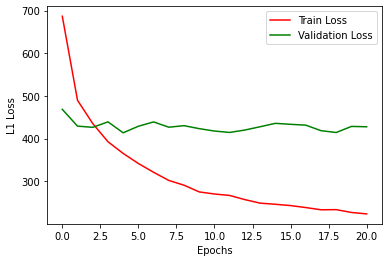

In [ ]:
plt.plot(history["train_loss"], c = "r", label = "Train Loss")
plt.plot(history["val_loss"], c = "g", label = "Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("L1 Loss")
plt.show()

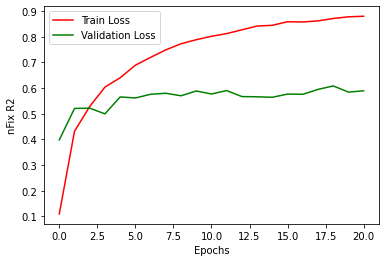

In [ ]:
plt.plot(history["train_nFix"], c = "r", label = "Train Loss")
plt.plot(history["val_nFix"], c = "g", label = "Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("nFix R2")
plt.show()

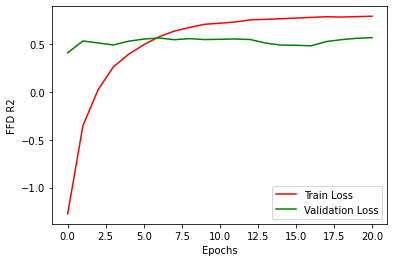

In [ ]:
plt.plot(history["train_FFD"], c = "r", label = "Train Loss")
plt.plot(history["val_FFD"], c = "g", label = "Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("FFD R2")
plt.show()

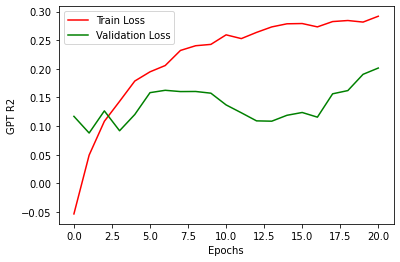

In [ ]:
plt.plot(history["train_GPT"], c = "r", label = "Train Loss")
plt.plot(history["val_GPT"], c = "g", label = "Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("GPT R2")
plt.show()

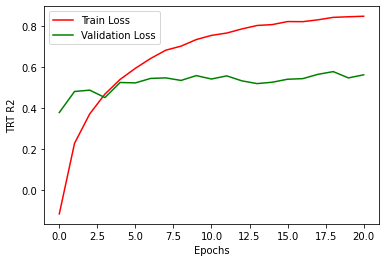

In [ ]:
plt.plot(history["train_TRT"], c = "r", label = "Train Loss")
plt.plot(history["val_TRT"], c = "g", label = "Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("TRT R2")
plt.show()

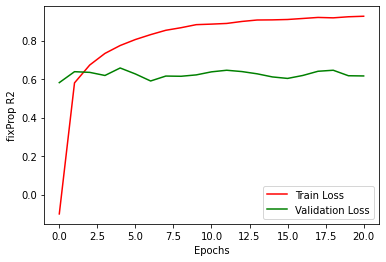

In [ ]:
plt.plot(history["train_fixProp"], c = "r", label = "Train Loss")
plt.plot(history["val_fixProp"], c = "g", label = "Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("fixProp R2")
plt.show()

In [ ]:
display_data = [[best["train_loss"], best["train_nFix"], best["train_FFD"], best["train_GPT"], best["train_TRT"], best["train_fixProp"]],
 [best["val_loss"], best["val_nFix"], best["val_FFD"], best["val_GPT"], best["val_TRT"], best["val_fixProp"]]]

display_df = pd.DataFrame(display_data, columns = ["L1Loss", "nFix", "FFD", "GPT", "TRT", "fixProp"], index = ["Train", "Val"]) 

In [ ]:
display_df

,L1Loss,nFix,FFD,GPT,TRT,fixProp
Train,365.216875,0.640278,0.394902,0.178661,0.54005,0.774523
Val,413.559586,0.565516,0.532156,0.120205,0.52500,0.657828


In [ ]:
display_data2 = [[history["train_loss"][-1], history["train_nFix"][-1], history["train_FFD"][-1], history["train_GPT"][-1], history["train_TRT"][-1], history["train_fixProp"][-1]], 
                 [history["val_loss"][-1], history["val_nFix"][-1], history["val_FFD"][-1], history["val_GPT"][-1], history["val_TRT"][-1], history["val_fixProp"][-1]]]
display_df2 = pd.DataFrame(display_data2, columns = ["L1Loss", "nFix", "FFD", "GPT", "TRT", "fixProp"], index = ["Train ", "Val "]) 

In [ ]:
display_df2

,L1Loss,nFix,FFD,GPT,TRT,fixProp
Train,223.438507,0.880101,0.793632,0.291844,0.847569,0.926553
Val,427.720608,0.589386,0.569742,0.201355,0.562377,0.616472


In [ ]:
history["train_loss"][0], history["val_loss"][0]

(813.3232115336826, 709.8956445058187)

In [ ]:
save_file_path = "/content/drive/My Drive/CMCL Shared Task/BertForToken.pth"
torch.save(model.state_dict(), save_file_path)

In [ ]:
del model

In [ ]:
'''
IDEAS:
Training :-
1. Sentence Formation.
2. BERT tokenize.
3. Base BERT Model -> if encoded value == 0 -> 5 output Dense Layer.
4. MAE metric for loss calculation.

Test :-
1. Sentence Formation.
2. BERT Tokenize.
3. Base BERT Model  -> if encoded value == 0 -> 5 output Dense Layer.
4. Order is maintained and predictions are pasted on the csv file.
'''